# CSX46 - Class Session 13 - Correlation network

In this class session we are going to analyze gene expression data from a human bladder cancer cohort, using python. We will load a data matrix of expression measurements of 4,473 genes in 414 different bladder cancer samples. These genes have been selected because they are differentially expressed between normal bladder and bladder cancer (thus more likely to have a function in bladder cancer specifically), but the columns in the data matrix are restricted to bladder cancer samples (not normal bladder) because we want to obtain a network representing variation across cancers. The measurements in the matrix have already been normalized to account for inter-sample heterogeneity and then log2 transformed. Our job is to compute Pearson correlation coefficients between all pairs of genes, obtain Fisher-transformed *z*-scores for all pairs of genes, test each pair of genes for significance of the *z* score, adjust for multiple hypothesis testing, filter to eliminate any pair for which *R* < 0.75 or *P*adj > 0.01, load the graph into an `igraph.Graph` object, and plot the degree distribution on log-log scale. We will then answer two questions: (1) does the network look to be scale-free? and (2) what is it's best-fit scaling exponent?

We will start by importing all of the modules that we will need for this notebook. Note the difference in language-design philosophy between R (which requires loading one package for this analysis) and python (where we have to load seven modules). Python keeps its core minimal, whereas R has a lot of statistical and plotting functions in the base language (or in packages that are loaded by default).

In [1]:
import pandas
import scipy.stats
import matplotlib
import pylab
import numpy
import statsmodels.sandbox.stats.multicomp
import igraph
import math

Using `pandas.read_csv`, load the tab-deliminted text file of gene expression measurements (rows correspond to genes, columns correspond to bladder tumor samples), into a data frame `gene_matrix_for_network_df`.

In [2]:
gene_matrix_for_network_df = pandas.read_csv("shared/bladder_cancer_genes_tcga.txt", sep="\t")

Use the `pandas.DataFrame.values` attribute to make a matrix `gene_matrix_for_network`. Print out the dimensions of the matrix, by accessing its `shape` variable

In [5]:
gene_matrix_for_network = gene_matrix_for_network_df.values
gene_matrix_for_network.shape

(4473, 414)

Use `del` to delete the data frame, since we no longer need it (save memory)

In [6]:
del gene_matrix_for_network_df

Look at the online help for the `numpy.corrcoef` function, using `help(numpy.corrcoef)`.  When you pass a single argument `x` which is a 2D "array" (i.e., a matrix), by default does `corrcoef` compute coefficients for pairs of rows, or pairs of columns?

In [7]:
help(numpy.corrcoef)

Help on function corrcoef in module numpy:

corrcoef(x, y=None, rowvar=True, bias=<no value>, ddof=<no value>)
    Return Pearson product-moment correlation coefficients.
    
    Please refer to the documentation for `cov` for more detail.  The
    relationship between the correlation coefficient matrix, `R`, and the
    covariance matrix, `C`, is
    
    .. math:: R_{ij} = \frac{ C_{ij} } { \sqrt{ C_{ii} * C_{jj} } }
    
    The values of `R` are between -1 and 1, inclusive.
    
    Parameters
    ----------
    x : array_like
        A 1-D or 2-D array containing multiple variables and observations.
        Each row of `x` represents a variable, and each column a single
        observation of all those variables. Also see `rowvar` below.
    y : array_like, optional
        An additional set of variables and observations. `y` has the same
        shape as `x`.
    rowvar : bool, optional
        If `rowvar` is True (default), then each row represents a
        variable, with obse

Compute the 4,473 x 4,473 matrix of gene-gene Pearson correlation coefficients, using `numpy.corrcoef` (this function treats each row as a variable, so you don't have to do any transposing of the matrix, unlike the situation in R).

In [8]:
gene_matrix_for_network_cor = numpy.corrcoef(gene_matrix_for_network)

Look at the online help for `numpy.fill_diagonal`.  Does it return the modified matrix or modify the matrix argument in place?

In [9]:
help(numpy.fill_diagonal)

Help on function fill_diagonal in module numpy:

fill_diagonal(a, val, wrap=False)
    Fill the main diagonal of the given array of any dimensionality.
    
    For an array `a` with ``a.ndim >= 2``, the diagonal is the list of
    locations with indices ``a[i, ..., i]`` all identical. This function
    modifies the input array in-place, it does not return a value.
    
    Parameters
    ----------
    a : array, at least 2-D.
      Array whose diagonal is to be filled, it gets modified in-place.
    
    val : scalar
      Value to be written on the diagonal, its type must be compatible with
      that of the array a.
    
    wrap : bool
      For tall matrices in NumPy version up to 1.6.2, the
      diagonal "wrapped" after N columns. You can have this behavior
      with this option. This affects only tall matrices.
    
    See also
    --------
    diag_indices, diag_indices_from
    
    Notes
    -----
    .. versionadded:: 1.4.0
    
    This functionality can be obtained via

Set the diagonal elements of the matrix to zero, using `numpy.fill_diagonal`

In [10]:
numpy.fill_diagonal(gene_matrix_for_network_cor, 0)

Look at the online help for `numpy.multiply`.  Does it do element-wise multiplication or matrix multiplication?

In [11]:
help(numpy.multiply)

Help on ufunc object:

multiply = class ufunc(builtins.object)
 |  Functions that operate element by element on whole arrays.
 |  
 |  To see the documentation for a specific ufunc, use `info`.  For
 |  example, ``np.info(np.sin)``.  Because ufuncs are written in C
 |  (for speed) and linked into Python with NumPy's ufunc facility,
 |  Python's help() function finds this page whenever help() is called
 |  on a ufunc.
 |  
 |  A detailed explanation of ufuncs can be found in the docs for :ref:`ufuncs`.
 |  
 |  Calling ufuncs:
 |  ===============
 |  
 |  op(*x[, out], where=True, **kwargs)
 |  Apply `op` to the arguments `*x` elementwise, broadcasting the arguments.
 |  
 |  The broadcasting rules are:
 |  
 |  * Dimensions of length 1 may be prepended to either array.
 |  * Arrays may be repeated along dimensions of length 1.
 |  
 |  Parameters
 |  ----------
 |  *x : array_like
 |      Input arrays.
 |  out : ndarray, None, or tuple of ndarray and None, optional
 |      Alternate ar

Look at the online help for `numpy.tri`.  Does it modify a matrix argument in-place or return a matrix?  What is in the matrix that it returns?

In [12]:
help(numpy.tri)

Help on function tri in module numpy:

tri(N, M=None, k=0, dtype=<class 'float'>)
    An array with ones at and below the given diagonal and zeros elsewhere.
    
    Parameters
    ----------
    N : int
        Number of rows in the array.
    M : int, optional
        Number of columns in the array.
        By default, `M` is taken equal to `N`.
    k : int, optional
        The sub-diagonal at and below which the array is filled.
        `k` = 0 is the main diagonal, while `k` < 0 is below it,
        and `k` > 0 is above.  The default is 0.
    dtype : dtype, optional
        Data type of the returned array.  The default is float.
    
    Returns
    -------
    tri : ndarray of shape (N, M)
        Array with its lower triangle filled with ones and zero elsewhere;
        in other words ``T[i,j] == 1`` for ``i <= j + k``, 0 otherwise.
    
    Examples
    --------
    >>> np.tri(3, 5, 2, dtype=int)
    array([[1, 1, 1, 0, 0],
           [1, 1, 1, 1, 0],
           [1, 1, 1, 1, 

Set the upper-triangle of the matrix to zero, using `numpy.multiply` and `numpy.tri` (for `numpy.tri`, you will want to use the single-asterisk argument syntax):

In [14]:
gene_matrix_for_network_cor = numpy.multiply(gene_matrix_for_network_cor, numpy.tri(*gene_matrix_for_network_cor.shape))

Using `numpy.where`, get a tuple of two numpy.arrays containing the row/col indices of the entries of the matrix for which *R* >= 0.75. Use array indexing to obtain the *R* values for these matrix entries, as a numpy array `cor_coeff_values_above_thresh`.

In [15]:
inds_correl_above_thresh = numpy.where(gene_matrix_for_network_cor >= 0.75)
cor_coeff_values_above_thresh = gene_matrix_for_network_cor[inds_correl_above_thresh]

Refer to Eq. (13.5) in the assigned readding for today's class (p9 of the PDF).  Obtain a numpy array of the correlation coefficients that exceeded 0.75, and Fisher-transform the correlation coefficient values to get a vector `z_scores` of *z* scores. Each of these *z* scores will correspond to an **edge** in the network, unless the absolute *z* score is too small such that we can't exclude the null hypothesis that the corresponding two genes' expression values are indepdenent (we will perform that check in the next step).

In [16]:
z_scores = 0.5*numpy.log((1 + cor_coeff_values_above_thresh)/
                         (1 - cor_coeff_values_above_thresh))

Delete the correlation matrix object in order to save memory (we won't need it from here on out).

In [17]:
del gene_matrix_for_network_cor

Assume that under the null hypothesis that two genes are independent, then sqrt(M-3)z for the pair of genes is an independent sample from the normal distribution with zero mean and unit variance, where M is the number of samples used to compute the Pearson correlation coefficient (i.e., M = 414). For each entry in `z_scores` compute a *P* value as the area under two tails of the normal distribution N(x),  where the two tails are x < -sqrt(M-3)z and x > sqrt(M-3)z. (You'll know you are doing it right if z=0 means you get a P value of 1).  You will want to use the functions `numpy.abs` and `scipy.stats.norm.cdf`, as well as the `math.sqrt` function (in order to compute the square root).

In [18]:
M = gene_matrix_for_network.shape[1]
P_values = 2*scipy.stats.norm.cdf(-numpy.abs(z_scores)*math.sqrt(M-3))

Adjust the P values for multiple hypothesis testing, using the `statsmodels.sandbox.stats.multicomp.multipletests` function wth `method="fdr_bh"`

In [19]:
P_values_adj = statsmodels.sandbox.stats.multicomp.multipletests(P_values, method="fdr_bh")[1]

Verify that we don't need to drop any entries due to the adjusted P value not being small enough (use `numpy.where` and `len`); this should produce zero since we have M=414 samples per gene.

In [20]:
len(numpy.where(P_values_adj >= 0.01)[0])

0

Read the online help for the function `zip`.  What does it do?

In [21]:
help(zip)

Help on class zip in module builtins:

class zip(object)
 |  zip(iter1 [,iter2 [...]]) --> zip object
 |  
 |  Return a zip object whose .__next__() method returns a tuple where
 |  the i-th element comes from the i-th iterable argument.  The .__next__()
 |  method continues until the shortest iterable in the argument sequence
 |  is exhausted and then it raises StopIteration.
 |  
 |  Methods defined here:
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __next__(self, /)
 |      Implement next(self).
 |  
 |  __reduce__(...)
 |      Return state information for pickling.



We want to pass our tuple of numpy arrays containing row and column indices to `Graph.TupleList`; however, `Graph.TupleList` accepts a tuple list, not a tuple of numpy arrays. So we need to make a tuple list, using `zip`:

In [22]:
row_col_inds_tuple_list = zip(inds_correl_above_thresh[0], inds_correl_above_thresh[1])

## [note this can be done more elegantly using the unary "*" operator:
##    row_col_inds_tuple_list = zip(*inds_correl_above_thresh)  
##  see how we only need to type the variable name once, if we use the unary "*" ]

Make an undirected graph from the row/column indices of the (upper-triangle) gene pairs whose  correlations were above our threshold, using `igraph.Graph.TupleList`. Print a summary of the network, as a sanity check, using the `igraph.Graph.summary` method.

In [23]:
final_network = igraph.Graph.TupleList(row_col_inds_tuple_list)
final_network.summary()

'IGRAPH UN-- 1394 9916 -- \n+ attr: name (v)'

Plot the degree distribution on log-log scale; does it appear to be scale-free?

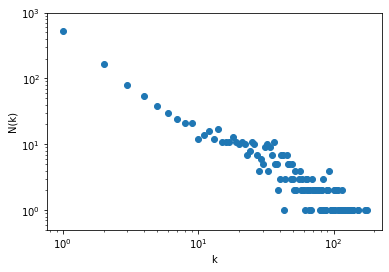

In [24]:
degree_dist = final_network.degree_distribution()
xs, ys = zip(*[(left, count) for left, _, count in degree_dist.bins()])
matplotlib.pyplot.scatter(xs, ys, marker="o")
ax = matplotlib.pyplot.gca()
ax.set_yscale("log")
ax.set_xscale("log")
matplotlib.pyplot.ylim((0.5,1000))
pylab.xlabel("k")
pylab.ylabel("N(k)")
pylab.show()

Use the `igraph.statistics.power_law_fit` function to estimate the scaling exponent *alpha* of the degree distribution:

In [25]:
igraph.statistics.power_law_fit(final_network.degree()).alpha

2.7453577551868795

Run the `community_walktrap()` method on the `final_network` object, and assign the result to `comm_res`.

In [28]:
comm_res = final_network.community_walktrap()

Plot the dendrogram using `igraph.plot`

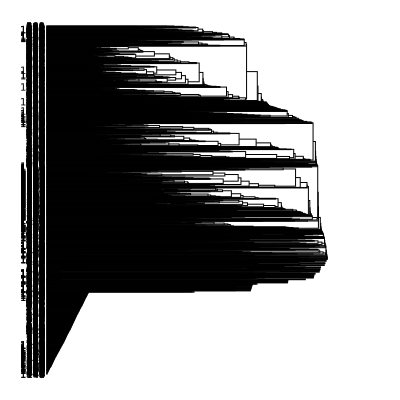

In [41]:
igraph.plot(comm_res, bbox=[0,0,400,400])

Use `sorted` (with `reverse=True`) and the `as_clustering()` and `sizes()` methods (chained) to examine sizes of the 20 largest clusters.

In [47]:
sorted(comm_res.as_clustering().sizes(), reverse=True)[0:20]

[392, 209, 147, 29, 9, 9, 8, 7, 7, 7, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5]

## extra challenge:
If you got this far, see if you can scatter plot the relationship between R (as the independent variable) and -log10(P) value (as the dependent variable).  When the effect size variable (e.g., *R*) can range from negative to positive, this plot is sometimes called a "volcano plot".

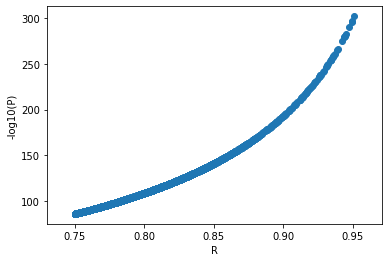

In [26]:
inds_use = numpy.where(P_values_adj > 0)
matplotlib.pyplot.scatter(cor_coeff_values_above_thresh[inds_use], -numpy.log10(P_values_adj[inds_use]))
pylab.xlabel("R")
pylab.ylabel("-log10(P)")
pylab.show()

## extra-extra challenge
For each of the gene pairs for which R>0.75, see if you can compute the t-test P value for each correlation coefficient (don't bother adjusting for false discovery rate control).  Compare to the (un-adjusted) P values that you got using the Fisher transformation, using a scatter plot.  How do they compare?  Which test has better statistical power, for this case where M = 414? (If you are wondering, *general* advice is to use Fisher if M>=10; for very small numbers of samples, use the Student t test).

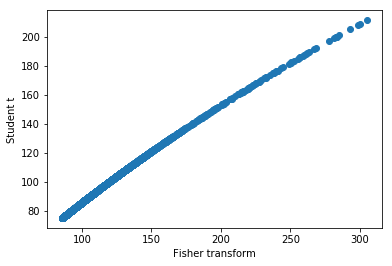

In [114]:
ts = numpy.divide(cor_coeff_values_above_thresh * math.sqrt(M - 2), numpy.sqrt(1 - cor_coeff_values_above_thresh**2))
P_values_studentT = 2*scipy.stats.t.cdf(-ts, M-2)
inds_use = numpy.where(numpy.logical_and(P_values > 0, P_values_studentT > 0))
matplotlib.pyplot.scatter(-numpy.log10(P_values[inds_use]),
                          -numpy.log10(P_values_studentT[inds_use]))
pylab.xlabel("Fisher transform")
pylab.ylabel("Student t")
pylab.show()